# The best place for you to live in São Paulo

This notebook presents the code used to solve the business problem I've proposed for IBM Data Science Certificate final project. My proposal was to segment São Paulo districts according to some characteristics in apartments avaliable for rent – more specifically: size, price of rent and price of condominuim, in order to help people to find the best place to live according to the amount of money they can spend on a rent and to some characteristics of the districts where this places are located. Please check the final report to see more details.

First of all, I've imported all libraries and packages necessary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import geocoder
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

My primary data is already avaliable at Kaggle plataform. After download it, I've opened the file with Pandas library to start to explore it

In [2]:
#open file
rent_path = 'properties-april-2019.csv'
rent = pd.read_csv(rent_path)
rent.head()

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  Furnished  \
0    930    220    47      2        2       1        1         0          0   
1   1000    148    45      2        2       1        1         0          0   
2   1000    100    48      2        2       1        1         0          0   
3   1000    200    48      2        2       1        1         0          0   
4   1300    410    55      2        2       1        1         1          0   

   Swimming Pool  New               District Negotiation Type Property Type  \
0              0    0  Artur Alvim/São Paulo             rent     apartment   
1              0    0  Artur Alvim/São Paulo             rent     apartment   
2              0    0  Artur Alvim/São Paulo             rent     apartment   
3              0    0  Artur Alvim/São Paulo             rent     apartment   
4              0    0  Artur Alvim/São Paulo             rent     apartment   

    Latitude  Longitude  
0 -23.543138 -46.479486  
1 -23.550239 -46.480718  
2 -23.542818 -46.485665  
3 -23.547171 -46.483014  
4 -23.525025 -46.482436

In [3]:
#check for null and missing values
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
Price               13640 non-null int64
Condo               13640 non-null int64
Size                13640 non-null int64
Rooms               13640 non-null int64
Toilets             13640 non-null int64
Suites              13640 non-null int64
Parking             13640 non-null int64
Elevator            13640 non-null int64
Furnished           13640 non-null int64
Swimming Pool       13640 non-null int64
New                 13640 non-null int64
District            13640 non-null object
Negotiation Type    13640 non-null object
Property Type       13640 non-null object
Latitude            13640 non-null float64
Longitude           13640 non-null float64
dtypes: float64(2), int64(11), object(3)
memory usage: 1.5+ MB


This data set is very consistent and don't present any null or missing values. After checking it, I've made some adjusts and selected only the rows and columns relevant for my problem. I've worked only with apartments for rent.

In [4]:
#adjust values from district column
rent['District'] = rent['District'].str.split('/').str[0]
rent['District'] = rent['District'] + ', SP'
rent.head()

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  Furnished  \
0    930    220    47      2        2       1        1         0          0   
1   1000    148    45      2        2       1        1         0          0   
2   1000    100    48      2        2       1        1         0          0   
3   1000    200    48      2        2       1        1         0          0   
4   1300    410    55      2        2       1        1         1          0   

   Swimming Pool  New         District Negotiation Type Property Type  \
0              0    0  Artur Alvim, SP             rent     apartment   
1              0    0  Artur Alvim, SP             rent     apartment   
2              0    0  Artur Alvim, SP             rent     apartment   
3              0    0  Artur Alvim, SP             rent     apartment   
4              0    0  Artur Alvim, SP             rent     apartment   

    Latitude  Longitude  
0 -23.543138 -46.479486  
1 -23.550239 -46.480718  
2 -23.542818 -46.485665  
3 -23.547171 -46.483014  
4 -23.525025 -46.482436

In [5]:
#select only apartments for rent
rent_final = rent.loc[rent['Negotiation Type'] == 'rent']

#select only columns relevant
rent_final = rent_final[['District', 'Price', 'Condo', 'Size', 'Latitude', 'Longitude']]
rent_final.head()

District  Price  Condo  Size   Latitude  Longitude
0  Artur Alvim, SP    930    220    47 -23.543138 -46.479486
1  Artur Alvim, SP   1000    148    45 -23.550239 -46.480718
2  Artur Alvim, SP   1000    100    48 -23.542818 -46.485665
3  Artur Alvim, SP   1000    200    48 -23.547171 -46.483014
4  Artur Alvim, SP   1300    410    55 -23.525025 -46.482436

In [6]:
rent_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 0 to 11209
Data columns (total 6 columns):
District     7228 non-null object
Price        7228 non-null int64
Condo        7228 non-null int64
Size         7228 non-null int64
Latitude     7228 non-null float64
Longitude    7228 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 367.0+ KB


This was my final data about apartments for rent. My next step was look for other information about the districts where these places are located. To do that, I've first needed to get the geocoordenates for each São Paulo district.

## Getting geocoordenates for each District

In [7]:
#select São Paulo districts
districts = rent_final['District']
districts_names = districts.unique()
print(type(districts_names))

<class 'numpy.ndarray'>


In [11]:
#get latitude and longitude for each district
lat = []
lng = []

for i in districts_names:
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    g = geocoder.arcgis(i)
    lat.append(g.latlng[0])
    lng.append(g.latlng[1])

print('Done!')

Done!


In [12]:
# put latitudes into a dataframe
latitude = { i : lat[i] for i in range(0, len(lat))}
latitude = pd.DataFrame.from_dict(latitude, orient='index')
latitude.rename(columns = {0:'District Latitude'}, inplace = True)
latitude.head()

District Latitude
0          -23.55105
1          -23.53805
2          -23.50602
3          -23.54798
4          -23.55843

In [13]:
# put longitudes into a dataframe
longitude = { i : lng[i] for i in range(0, len(lng))}
longitude = pd.DataFrame.from_dict(longitude, orient='index')
longitude.rename(columns = {0:'District Longitude'}, inplace = True)
longitude.head()

District Longitude
0           -46.48000
1           -46.59592
2           -46.52822
3           -46.53885
4           -46.47726

In [14]:
# transform district array into a dataframe
df_districts = pd.DataFrame(districts_names)

#merge the three dataframes into one
df_districts = pd.merge(df_districts, latitude, left_index=True, right_index=True)
df_districts = pd.merge(df_districts, longitude, left_index=True, right_index=True)

df_districts.head()

0  District Latitude  District Longitude
0   Artur Alvim, SP          -23.55105           -46.48000
1         Belém, SP          -23.53805           -46.59592
2      Cangaíba, SP          -23.50602           -46.52822
3        Carrão, SP          -23.54798           -46.53885
4  Cidade Líder, SP          -23.55843           -46.47726

In [15]:
#adjust column name
df_districts.rename(columns = {0: 'District'}, inplace = True)

In [16]:
df_districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 3 columns):
District              94 non-null object
District Latitude     94 non-null float64
District Longitude    94 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.9+ KB


## Getting Forsquare data about each district

With geocoordenates for each São Paulo districts in hand, I've use de Foursquare API to find cool places around them. To create the function, I've setted a radius default value of 1km (1000m) and limit the venues results by 200. According to API documentation, I've also used April 2019 version in order to keep consistent with my primary data.

In [17]:
CLIENT_ID = # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20190430'# Foursquare API version

In [18]:
# create a function that retrieve venues for each district

def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=200):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['name'],
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
            'Venue',
            'Venue Category']
    
    return(nearby_venues)

In [19]:
# apply the function into data
district_venues = getNearbyVenues(names=df_districts['District'], latitudes=df_districts['District Latitude'], longitudes=df_districts['District Longitude'])

Artur Alvim, SP
Belém, SP
Cangaíba, SP
Carrão, SP
Cidade Líder, SP
Cidade Tiradentes, SP
Ermelino Matarazzo, SP
Iguatemi, SP
Itaim Paulista, SP
Itaquera, SP
Jardim Helena, SP
José Bonifácio, SP
Lajeado, SP
Parque do Carmo, SP
Penha, SP
Ponte Rasa, SP
Sapopemba, SP
São Lucas, SP
São Mateus, SP
São Miguel, SP
São Rafael, SP
Tatuapé, SP
Vila Curuçá, SP
Vila Formosa, SP
Vila Jacuí, SP
Vila Matilde, SP
Vila Prudente, SP
Cambuci, SP
Campo Belo, SP
Campo Grande, SP
Campo Limpo, SP
Capão Redondo, SP
Cidade Ademar, SP
Cidade Dutra, SP
Cursino, SP
Grajaú, SP
Ipiranga, SP
Itaim Bibi, SP
Jabaquara, SP
Jardim Ângela, SP
Jardim Paulista, SP
Moema, SP
Morumbi, SP
Pedreira, SP
Sacomã, SP
Santo Amaro, SP
Saúde, SP
Socorro, SP
Vila Andrade, SP
Vila Mariana, SP
Vila Sônia, SP
Alto de Pinheiros, SP
Anhanguera, SP
Brasilândia, SP
Butantã, SP
Cachoeirinha, SP
Freguesia do Ó, SP
Jaguaré, SP
Jaraguá, SP
Lapa, SP
Limão, SP
Perdizes, SP
Pinheiros, SP
Pirituba, SP
Raposo Tavares, SP
Rio Pequeno, SP
Vila Leopoldi

In [20]:
print(district_venues.shape)
district_venues.head()

(5240, 3)


District                                            Venue  \
0  Artur Alvim, SP                            Restaurante Hiroshima   
1  Artur Alvim, SP             Sabor da Massa Rotisserie & Pizzaria   
2  Artur Alvim, SP                                Arena Corinthians   
3  Artur Alvim, SP  Casa do Povo: Tour Arena Corinthians (Portão A)   
4  Artur Alvim, SP                                   Poderoso Timão   

        Venue Category  
0  Japanese Restaurant  
1          Pizza Place  
2       Soccer Stadium  
3        Tour Provider  
4  Sporting Goods Shop

In [21]:
# check how many venues categories were retrieved
print(len(district_venues['Venue Category'].unique()))

343


In [22]:
# check how many districts has venues retrieved
print(len(district_venues['District'].unique()))

87


Not every district had places appearing in Foursquare (from 94 of them, 87 are listed in venues dataframe). This information was relevant when checking the final data set for missing values. But first, I've checked what kind of venues were retrieved for each district and added that to a new data set.

In [23]:
# count how many venues per category in each district
venues = district_venues.groupby(['District','Venue Category']).count()
venues = venues.reset_index()

In [24]:
venues.head()

District            Venue Category  Venue
0  Alto de Pinheiros, SP        Athletics & Sports      3
1  Alto de Pinheiros, SP                       Bar      2
2  Alto de Pinheiros, SP  Bike Rental / Bike Share      1
3  Alto de Pinheiros, SP            Breakfast Spot      1
4  Alto de Pinheiros, SP                      Café      1

In [25]:
# rearange venues by most common ones
venues = venues.sort_values('Venue',ascending=False)

# put them into one single column
strJoin = lambda x:", ".join(x.astype(str))
sampa_venues = venues.groupby('District', as_index=True, sort=False).agg(name=('Venue Category', strJoin))
sampa_venues = sampa_venues.reset_index()
sampa_venues.head()

District                                               name
0          Liberdade, SP  Japanese Restaurant, Chinese Restaurant, Asian...
1       Vila Formosa, SP  Bakery, Pizza Place, Plaza, Pharmacy, Ice Crea...
2               Lapa, SP  Pharmacy, Restaurant, Brazilian Restaurant, Ba...
3           Brooklin, SP  Brazilian Restaurant, Gym, Bakery, Bar, Restau...
4  Alto de Pinheiros, SP  Plaza, Athletics & Sports, Restaurant, Bar, Fo...

In [26]:
# adjust column name
sampa_venues.rename(columns = {'name': 'Cool places in district'}, inplace = True)

In [27]:
sampa_venues.shape

(87, 2)

In [28]:
sampa_venues.sample(5)

District                            Cool places in district
27         Tatuapé, SP  Restaurant, Pizza Place, Dessert Shop, Bar, Br...
80      Anhanguera, SP  Lake, Brazilian Restaurant, Nature Preserve, R...
8    Santa Cecília, SP  Pizza Place, Italian Restaurant, Brazilian Res...
24  Freguesia do Ó, SP  Pizza Place, Brazilian Restaurant, Pharmacy, G...
18      Casa Verde, SP  Bar, Plaza, Restaurant, Bakery, Gym / Fitness ...

In [29]:
# create the final data set with information about apartments and venues around districts
dataset = pd.merge(rent_final, sampa_venues, how='left', on='District')

In [30]:
dataset.sample(5)

District  Price  Condo  Size   Latitude  Longitude  \
5814     Sapopemba, SP    900      0    45 -23.616230 -46.488050   
1951      Perdizes, SP   4000   1078   104 -23.530014 -46.687508   
4181  Vila Mariana, SP   3500    174   130 -23.579947 -46.651211   
5932    Campo Belo, SP   3500    600    49 -23.625116 -46.665969   
1014       Cursino, SP   2300    836    94 -23.630909 -46.617665   

                                Cool places in district  
5814                                                NaN  
1951  Dessert Shop, Bar, Pet Store, Bakery, Burger J...  
4181  Dessert Shop, Ice Cream Shop, Hostel, Burger J...  
5932  Spa, Pizza Place, Bar, Dessert Shop, Bakery, P...  
1014  Bakery, Brazilian Restaurant, Farmers Market, ...

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 0 to 7227
Data columns (total 7 columns):
District                   7228 non-null object
Price                      7228 non-null int64
Condo                      7228 non-null int64
Size                       7228 non-null int64
Latitude                   7228 non-null float64
Longitude                  7228 non-null float64
Cool places in district    6776 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 395.3+ KB


So, my final dataset has 7228 rows and 7 columns. Some of them has no venues assigned, so I needed to fill this blank data with some message for the public.

In [32]:
#adjust missing venues
dataset.replace(np.nan, 'no venues', inplace=True)

In [34]:
dataset.sample(5)

District  Price  Condo  Size   Latitude  Longitude  \
5508        Santana, SP   1450    150    60 -23.501052 -46.622735   
1936       Perdizes, SP   3400   1210   127 -23.537844 -46.673038   
6082        Morumbi, SP   2550   1250   160 -23.625822 -46.731020   
6107          Saúde, SP   1600    474    48 -23.619414 -46.640704   
898   Capão Redondo, SP   1100    400    38 -23.673344 -46.759760   

                                Cool places in district  
5508  Pizza Place, Japanese Restaurant, Burger Joint...  
1936  Dessert Shop, Bar, Pet Store, Bakery, Burger J...  
6082  Café, Soccer Stadium, Plaza, Restaurant, Coffe...  
6107  Pizza Place, Japanese Restaurant, Dessert Shop...  
898                                           no venues

# Segmenting São Paulo districts

Then I could finally segment São Paulo districts according to apartments features. For this project, I've select only size, price of rent and condominium to apply a non-supervised machine learn agorithm - Kmeans - to these data.

In [35]:
#Select data columns to cluster
rent_cluster = dataset[['Price', 'Condo', 'Size']]
rent_cluster.head()

Price  Condo  Size
0    930    220    47
1   1000    148    45
2   1000    100    48
3   1000    200    48
4   1300    410    55

In [36]:
# find the best k
kc = range(1,10)
distorcions = []

for k in kc:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rent_cluster)
    distorcions.append(sum(np.min(cdist(rent_cluster, kmeans.cluster_centers_, 'euclidean'), axis=1)) / rent_cluster.shape[0])

print('Done!')

Done!


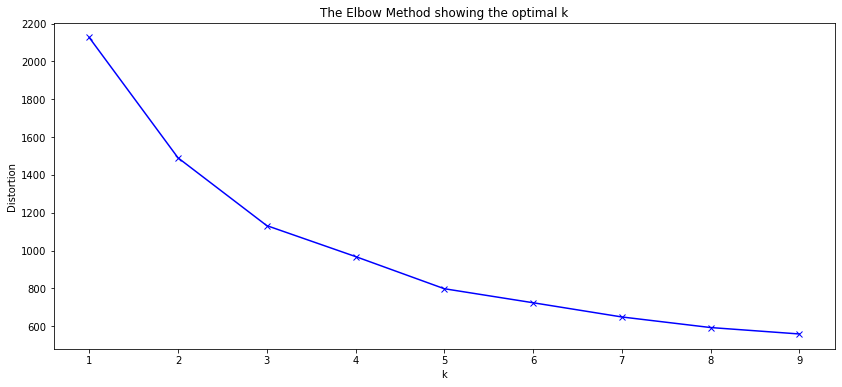

In [37]:
# show distorcions of k - elbow point
plt.figure(figsize=(14,6))
plt.plot(kc, distorcions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
# clustering with best k
kmeans = KMeans(n_clusters=5, random_state=0).fit(rent_cluster)

#check the labels
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
# add clustering labels into neighborhood's venues dataframe
dataset.insert(3, 'Cluster Labels', kmeans.labels_)
dataset.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
3362     Cambuci, SP   1500    361               0    48 -23.565851   
5349   República, SP   1100    310               0    30 -23.542990   
7200       Mooca, SP   2100   2100               0   180 -23.575646   
5598  Vila Maria, SP    750    382               0    56 -23.516653   
7034    Perdizes, SP   2700   1292               3   127 -23.533830   

      Longitude                            Cool places in district  
3362 -46.619332  Brazilian Restaurant, Restaurant, Farmers Mark...  
5349 -46.645620                                          no venues  
7200 -46.591103  Bar, Brazilian Restaurant, Pizza Place, Bakery...  
5598 -46.589880  Bar, Bakery, Soccer Field, Pharmacy, Beer Gard...  
7034 -46.678955  Dessert Shop, Bar, Pet Store, Bakery, Burger J...

## Exploring clusters

I've explored the clusters. A breaf description of them are presented bellow, among with a map that shows every apartment location and cluster they belong to.

### 1 - Small sizes and prices

This cluster have the smaller sizes (<100m²) and rent/condominium prices of apartments. It's also the bigger cluster, with more than 4700 places avaliable to rent in different districts. It's probably the first choice for most part of future renters.

In [40]:
# cluster labels = 0
cluster_0 = dataset.loc[dataset['Cluster Labels'] == 0]
cluster_0.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
662      Vila Matilde, SP   1000     10               0    90 -23.549016   
6531         Cangaíba, SP   1000    460               0    50 -23.500451   
940     Cidade Ademar, SP   1740    732               0    74 -23.665443   
6331  Vila Leopoldina, SP   2500    537               0    70 -23.531945   
1410          Socorro, SP   1400    680               0    72 -23.690717   

      Longitude                            Cool places in district  
662  -46.512358  Pizza Place, Ice Cream Shop, Farmers Market, P...  
6531 -46.523592  Pizza Place, Bakery, Soccer Field, Bar, Plaza,...  
940  -46.659179  Bakery, Restaurant, Pharmacy, Gym / Fitness Ce...  
6331 -46.744978  Brazilian Restaurant, Pizza Place, Flower Shop...  
1410 -46.699765  Café, Italian Restaurant, Snack Place, Plaza, ...

In [41]:
#check max values for price and size
print('Most expensive rent: R$', cluster_0['Price'].max())
print('Most expensive condominium: R$', cluster_0['Condo'].max())
print('Mean size: ', format(cluster_0['Size'].mean(),'.0f'), 'm²')
print('Apartments sizes range from', format(cluster_0['Size'].min()), 'to', format(cluster_0['Size'].max()), 'm²')

Most expensive rent: R$ 2850
Most expensive condominium: R$ 2893
Mean size:  63 m²
Apartments sizes range from 30 to 300 m²


In [42]:
cluster_0.shape

(4767, 8)

### 2 - Big sizes and prices

With high costs and apartments sizes (<300m²), future renters in this area must have a very good personal budget. It can be a good choice for people with many roommates or big families.

In [43]:
# cluster labels = 1
cluster_1 = dataset.loc[dataset['Cluster Labels'] == 1]
cluster_1.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  Longitude  \
1851   Jaraguá, SP  12500   3000               1   397 -23.523537 -46.648652   
230   Iguatemi, SP  21000      0               1   223 -23.585700 -46.682600   
235   Iguatemi, SP  20000   2800               1   250 -23.583577 -46.683324   
1221     Moema, SP  12500   2900               1   165 -23.604746 -46.665565   
3916   Morumbi, SP  12950      0               1   207 -23.637584 -46.726968   

                                Cool places in district  
1851  Pizza Place, Gym / Fitness Center, Gym, Bakery...  
230   Steakhouse, Pizza Place, Food Stand, Food & Dr...  
235   Steakhouse, Pizza Place, Food Stand, Food & Dr...  
1221  Ice Cream Shop, Japanese Restaurant, Dessert S...  
3916  Café, Soccer Stadium, Plaza, Restaurant, Coffe...

In [44]:
#check max values for price and size
print('Most expensive rent: R$', cluster_1['Price'].max())
print('Most expensive condominium: R$', cluster_1['Condo'].max())
print('Mean size: ', format(cluster_1['Size'].mean(),'.0f'), 'm²')
print('Apartments sizes range from', format(cluster_1['Size'].min()), 'to', format(cluster_1['Size'].max()), 'm²')

Most expensive rent: R$ 23000
Most expensive condominium: R$ 8000
Mean size:  250 m²
Apartments sizes range from 58 to 880 m²


In [45]:
cluster_1.shape

(193, 8)

### 3 - A+ Class

This is the most expensive and exclusive cluster of all. It has only 35 hughe (>300m²) and really expensive apartments avaliable for rent. Ok, this is for the rich ones.

In [46]:
# cluster labels = 2
cluster_2 = dataset.loc[dataset['Cluster Labels'] == 2]
cluster_2.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
7072          Pinheiros, SP  38000   3800               2   332 -23.561994   
4720          Pinheiros, SP  30000   4739               2   354 -23.562134   
1242              Moema, SP  25000   1600               2   209 -23.607432   
6187  Alto de Pinheiros, SP  24000   4710               2   364 -23.556693   
6184  Alto de Pinheiros, SP  27000   6000               2   319 -23.560628   

      Longitude                            Cool places in district  
7072 -46.689899  Bar, Art Gallery, Italian Restaurant, Café, Ic...  
4720 -46.700207  Bar, Art Gallery, Italian Restaurant, Café, Ic...  
1242 -46.664542  Ice Cream Shop, Japanese Restaurant, Dessert S...  
6187 -46.712710  Plaza, Athletics & Sports, Restaurant, Bar, Fo...  
6184 -46.700701  Plaza, Athletics & Sports, Restaurant, Bar, Fo...

In [47]:
#check max values for price and size
print('Most expensive rent: R$', cluster_2['Price'].max())
print('Most expensive condominium: R$', cluster_2['Condo'].max())
print('Mean size: ', format(cluster_2['Size'].mean(),'.0f'), 'm²')
print('Apartments sizes range from', format(cluster_2['Size'].min()), 'to', format(cluster_2['Size'].max()), 'm²')

Most expensive rent: R$ 50000
Most expensive condominium: R$ 8800
Mean size:  367 m²
Apartments sizes range from 209 to 670 m²


In [48]:
cluster_2.shape

(35, 8)

### 4 - Small families

This cluster is almost similar with the first one, but all prices and sizes (>100m²) are a little bit higher. This can be a good choice for one or two roommates and small families.

In [49]:
# cluster labels = 3
cluster_3 = dataset.loc[dataset['Cluster Labels'] == 3]
cluster_3.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
2136        Barra Funda, SP   3000    844               3    66 -23.520024   
3534           Ipiranga, SP   4600      0               3   146 -23.584328   
5284         Consolação, SP   2800    657               3    95 -23.554072   
4263  Alto de Pinheiros, SP   4900    786               3    74 -23.541080   
3881            Morumbi, SP   2500   1600               3   140 -23.620404   

      Longitude                            Cool places in district  
2136 -46.675898  Brazilian Restaurant, Pizza Place, Restaurant,...  
3534 -46.602600  Brazilian Restaurant, Burger Joint, Bar, Baker...  
5284 -46.659189  Coffee Shop, Bar, Brazilian Restaurant, Gym / ...  
4263 -46.698283  Plaza, Athletics & Sports, Restaurant, Bar, Fo...  
3881 -46.737597  Café, Soccer Stadium, Plaza, Restaurant, Coffe...

In [50]:
#check max values for price and size
print('Most expensive rent: R$', cluster_3['Price'].max())
print('Most expensive condominium: R$', cluster_3['Condo'].max())
print('Size mean: ', format(cluster_3['Size'].mean(),'.0f'), 'm²')
print('Apartments sizes range from', format(cluster_3['Size'].min()), 'to', format(cluster_3['Size'].max()), 'm²')

Most expensive rent: R$ 6000
Most expensive condominium: R$ 7500
Size mean:  110 m²
Apartments sizes range from 30 to 440 m²


In [51]:
cluster_3.shape

(1674, 8)

### 5 - Very good personal budget

Following the previous cluster, this last one increases a little bit more all prices and sizes of apartments, wich can be a good choice for roommates and small families with a large personal budget.

In [52]:
# cluster labels = 4
cluster_4 = dataset.loc[dataset['Cluster Labels'] == 4]
cluster_4.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
4281  Alto de Pinheiros, SP  10000   2500               4   163 -23.539193   
1216              Moema, SP   6000   1700               4   198 -23.609373   
3809              Moema, SP   6000   1380               4   168 -23.607508   
2233         Bela Vista, SP   6000   3300               4   390 -23.570194   
3750    Jardim Paulista, SP   5800   1500               4   182 -23.566994   

      Longitude                            Cool places in district  
4281 -46.713697  Plaza, Athletics & Sports, Restaurant, Bar, Fo...  
1216 -46.659818  Ice Cream Shop, Japanese Restaurant, Dessert S...  
3809 -46.663905  Ice Cream Shop, Japanese Restaurant, Dessert S...  
2233 -46.655883                                          no venues  
3750 -46.660656  Bakery, Pizza Place, Japanese Restaurant, Rest...

In [53]:
#check max values for price and size
print('Most expensive rent: R$', cluster_4['Price'].max())
print('Most expensive condominium: R$', cluster_4['Condo'].max())
print('Size mean: ', format(cluster_4['Size'].mean(),'.0f'), 'm²')
print('Apartments sizes range from', format(cluster_4['Size'].min()), 'to', format(cluster_4['Size'].max()), 'm²')

Most expensive rent: R$ 11600
Most expensive condominium: R$ 9500
Size mean:  180 m²
Apartments sizes range from 35 to 852 m²


In [54]:
cluster_4.shape

(559, 8)

# Clustering visualization in São Paulo Map

All places, big or small, cheap or expensive, are equaly distributed into districts, wich is expected since my clustering task didn't include location as a feature. So, it's important to note and remember that mos part of districts has avaliable apartments from diferent clusters, with means that they can suit diferent tipe of personal budgets and necessities. Here is a map visualization of that:

In [55]:
# get geocoordenates from São Paulo
url = 'https://maps.googleapis.com/maps/api/geocode/json'
g = geocoder.arcgis('São Paulo, BR')
g.latlng

[-23.562869999999975, -46.654679999999985]

In [56]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=g.latlng, zoom_start=13)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(dataset['Latitude'], dataset['Longitude'], dataset['District'], dataset['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters

This is it. Feel free to comment and share your thoughts. Thanks.